In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

In [ ]:
pip install d2l==0.17.6

In [ ]:
pip uninstall matplotlib

In [ ]:
pip install --upgrade pip

In [ ]:
pip install matplotlib

# 7.1 深度卷积神经网络（AlexNet）

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
                    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
                    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                    nn.Flatten(),
                    nn.Linear(256 * 5 * 5, 4096), nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(4096, 4096), nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(4096, 10))
X = torch.randn(1, 1, 224, 224)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [ ]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.2 使用块的网络（VGG）

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
    in_channels = out_channels
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)) # 定义5个VGG块，括号表示卷积层的个数和输出通道数

In [ ]:
def vgg(conv_arch):
  conv_blks = []
  in_channels = 1
  # 卷积层部分
  for (num_convs, out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
    in_channels = out_channels
  return nn.Sequential(
      *conv_blks,
      nn.Flatten(),
      # 全连接层
      nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(p=0.5),
      nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
      nn.Linear(4096, 10)
  )

net = vgg(conv_arch)
X = torch.randn((1, 1, 224, 224))
for blk in net:
  X = blk(X)
  print(blk.__class__.__name__,'out shape:\t',X.shape)

Sequential out shape:	 torch.Size([1, 64, 112, 112])
Sequential out shape:	 torch.Size([1, 128, 56, 56])
Sequential out shape:	 torch.Size([1, 256, 28, 28])
Sequential out shape:	 torch.Size([1, 512, 14, 14])
Sequential out shape:	 torch.Size([1, 512, 7, 7])
Flatten out shape:	 torch.Size([1, 25088])
Linear out shape:	 torch.Size([1, 4096])
ReLU out shape:	 torch.Size([1, 4096])
Dropout out shape:	 torch.Size([1, 4096])
Linear out shape:	 torch.Size([1, 4096])
ReLU out shape:	 torch.Size([1, 4096])
Dropout out shape:	 torch.Size([1, 4096])
Linear out shape:	 torch.Size([1, 10])


In [ ]:
# 训练模型
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.3 网络中的网络（NiN）

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, stride, padding):
  return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding), nn.ReLU(),
                       nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
                       nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

In [ ]:
from torch.nn.modules.pooling import AdaptiveAvgPool2d
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, stride=4, padding=0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(96, 256, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(256, 384, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Dropout(p=0.5),
    nin_block(384, 10, kernel_size=3, stride=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [ ]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.4 含并行连接的网络（GoogLeNet）

In [ ]:
from IPython.utils.py3compat import PY3
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# Inception块的定义：
class Inception(nn.Module):
  # c1--c4是每条路径的输出通道数
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs)
    # 路径一：单1x1卷积层
    self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
    # 路径二：1x1卷积层后接3x3卷积层
    self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
    self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
    # 路径三：1x1卷积层后接5x5卷积层
    self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
    self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
    # 路径四：3x3最大池化层后接1x1卷积层
    self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

  def forward(self, x):
    p1 = F.relu(self.p1_1(x))
    p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
    p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
    p4 = F.relu(self.p4_2(self.p4_1(x)))
    # 在通道维度上连接输出
    return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
# GoogLeNet模型
# stage1:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# stage2:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, stride=2, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# stage3:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# stage4:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# stage5:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)),
                   nn.Flatten())
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shapeL:\t',X.shape)

Sequential output shapeL:	 torch.Size([1, 64, 56, 56])
Sequential output shapeL:	 torch.Size([1, 192, 14, 14])
Sequential output shapeL:	 torch.Size([1, 480, 7, 7])
Sequential output shapeL:	 torch.Size([1, 832, 4, 4])
Sequential output shapeL:	 torch.Size([1, 1024])
Linear output shapeL:	 torch.Size([1, 10])


In [ ]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.5 批量规范化

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  # 通过is_grad_enabled方法来判断当前模式是训练模式还是预测模式
  if not torch.is_grad_enabled():
    # 如果是在预测模式下，直接使用传入的移动平均所得的均质和方差
    X_hat = (X - moving_mean()) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2, 4)
    if len(X.shape) == 2:
      # 使用全连接层的情况，计算特征维上的均值和方差
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差
      # 这里我们需要保持X的形状以便后面可以做广播运算
      mean = X.mean(dim=(0, 2, 3), keepdim=True) # 分别表示批量大小，高，宽
      var = ((X - X.mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
    # 训练模式下，用当前的均值和方差做标准化
    X_hat = (X - mean()) / torch.sqrt(var + eps)
    # 更新移动平均的均值和方差
    moving_mean = momentum * moving_mean + (1.0 - momentum) * moving_mean
    moving_var = momentum * moving_var + (1.0 - momentum) * moving_var
  Y = gamma * X_hat + beta # 缩放和移位
  return Y, moving_mean.data, moving_var.data

In [ ]:
class BatchNorm(nn.Module):
  # num_features:全连接层的输出数量或卷积层的输出通道数量
  # num_dims:2表示全连接层，4表示卷积层
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    #参与求梯度和迭代的拉伸参数和偏移参数，其分别初始化为1和0
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeors(shape))
    # 非模型参数的变量初始化为0和1
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)

  def forward(self, X):
    # 如果X不在内存上，将moving_mean和moving_var复制到X所在的显存上
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    # 保存更新过的moving_mean和moving_var
    Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
    return Y

In [ ]:
# 使用批量规范化层的LeNet
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    BatchNorm(6, num_dims=4),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    BatchNorm(16, num_dims=4),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*4*4, 120),
    BatchNorm(120, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    BatchNorm(84, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
# 简明实现:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.BatchNorm2d(6),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*4*4, 120),
    BatchNorm(120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    BatchNorm(84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.6 残差网络（ResNet）

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [9]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [10]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [11]:
# ResNet模型
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), # 高宽减半
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 高宽减半
                   )

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [12]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [13]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.025, train acc 0.994, test acc 0.888
338.5 examples/sec on cuda:0


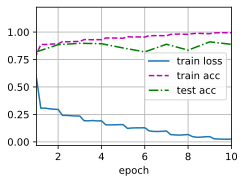

In [14]:
# 训练模型
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.7 稠密连接网络（DenseNet）

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

# 稠密块体
def conv_block(input_channels, num_channels):
  return nn.Sequential(nn.BatchNorm2d(input_channels), nn.ReLU(),
                       nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

class DenseBlock(nn.Module):
  def __init__(self, num_convs, input_channels, num_channels):
    super(DenseBlock, self).__init__()
    layer = []
    for i in range(num_convs):
      layer.append(conv_block(input_channels + num_channels * i, num_channels))
    self.net = nn.Sequential(*layer)

  def forward(self, X):
    for blk in self.net:
      Y = blk(X)
      # 连接通道维度上每个卷积块的输入和输出
      X = torch.cat((X, Y), dim=1)
    return X

In [6]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [8]:
# 过渡层
def transition_block(input_channels, num_channels):
  return nn.Sequential(
      nn.BatchNorm2d(input_channels), nn.ReLU(),
      nn.Conv2d(input_channels, num_channels, kernel_size=1), # 减小通道数
      nn.AvgPool2d(kernel_size=2, stride=2) # 高宽减半
  )

blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [ ]:
# DenseNet模型
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MacPool2d(kernel_size=3, stride=2, padding=1)
)

# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_block = [4, 4, 4, 4] # 使用四个稠密块，每个稠密块使用4个卷积层
blks = []
for i, num_convs in enumerate(num_convs_in_dense_block):
  blks.append(DenseBlock(num_convs, num_channels, growth_rate))
  # 上一个稠密块的输出通道数
  num_channels += num_convs * growth_rate
  # 在稠密块之间添加一个过渡层，使通道数减半
  if i != len(num_convs_in_dense_block) - 1:
    blks.append(transition_block(num_channels, num_channels // 2))
    num_channels = num_channels // 2

net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

In [ ]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())